In [12]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

import torchvision
import os
from PIL import Image

In [13]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [14]:
from constants import csv_file, directory, INPUT_SHAPE, YEAR, ext

from utils import Dataset_Diabetic, data_class
from utils import (
    plot_samples,
    get_dataloader,
    plot_confusion_matrix,
    calculate_confusion_matrix,
    accuracy_fn,
    accuracy_sickness,
    get_accuracies,
)
from model import train_loop

from model import Model_Retinopathy

from constants import EPOCHS, BATCH_SIZE, LEARNING_RATE, UPDATES
from constants import K_CLIENTS, C, rounds, clients

In [15]:
# MODEL STUFF
global_model = Model_Retinopathy().to(device)
models = [Model_Retinopathy().to(device) for _ in range(K_CLIENTS)]
for model in models:
    model.set_weights(global_model.get_weights())

loss_fn = nn.CrossEntropyLoss()
# Best loss function when talking about multi-class classification
optimizer = torch.optim.Adam(global_model.parameters(), lr=LEARNING_RATE)

In [16]:
# DATA STUFF
df = pd.read_csv(csv_file)

val_df = df.sample(frac=0.05, random_state=200).reset_index(drop=True)
df = df.drop(val_df.index).reset_index(drop=True)

samples = df.shape[0] // K_CLIENTS
train_df = []

while len(train_df) < K_CLIENTS - 1:
    train_df.append(df.sample(n=samples, random_state=200).reset_index(drop=True))
    df = df.drop(train_df[-1].index).reset_index(drop=True)
train_df.append(df)

datasets, loaders = [], []
for train_df_i in train_df:
    data, loader = get_dataloader(train_df_i, ext, directory, BATCH_SIZE, True)
    datasets.append(data)
    loaders.append(loader)

val_data, val_loader = get_dataloader(val_df, ext, directory, BATCH_SIZE, False)

In [17]:
losses = []
accuracies = []
losses_clients = [[] for _ in range(K_CLIENTS)]
accuracies_clients = [[] for _ in range(K_CLIENTS)]

In [18]:
def plot_accuracies():
    fig, ax = plt.subplots()
    for i in range(K_CLIENTS):
        ax.plot(accuracies_clients[i], "o-")
    ax.plot(accuracies, "-", label="Global", linewidth=5, color="blue")
    ax.set_title(f"Accuracies comparison, {K_CLIENTS} clients")
    ax.set_xlabel("Rounds")
    ax.set_ylabel("Accuracy")
    ax.legend()
    return ax


def plot_losses():
    fig, ax = plt.subplots()
    for i in range(K_CLIENTS):
        ax.plot(losses_clients[i], "o-")
    ax.plot(losses, "-", label="Global Loss", linewidth=5, color="blue")
    ax.set_title(f"Losses comparison, {K_CLIENTS} clients")
    ax.set_xlabel("Rounds")
    ax.set_ylabel("Loss")
    ax.legend()
    return ax

In [19]:
def save_plots():
    plt.ioff()

    ax = plot_losses()
    plt.savefig("Losses_fed.png")
    plt.close()

    ax = plot_accuracies()
    plt.savefig("Accuracies_fed.png")
    plt.close()

In [20]:
def fed_avg():
    m_clients = int(max(1, K_CLIENTS * C))
    rounds = 20
    for t in range(rounds):
        print("ROUND: ", t)
        print("-------------------------------" * 3)
        weight_global = global_model.get_weights()
        selected_clients = np.random.choice(clients, m_clients, replace=False)
        selected_clients.sort()

        weights = [0] * K_CLIENTS
        m_t = sum([len(datasets[i]) for i in selected_clients])
        for client in selected_clients:
            local_model = Model_Retinopathy().to(device)
            local_model.set_weights(global_model.get_weights())

            print("TRAINING CLIENT", client, "Federated")
            train_loop(
                local_model,
                loaders[client],
                val_loader,
                epochs=EPOCHS,
                lr=LEARNING_RATE,
                verbose=False,
            )
            print("TRAINING CLIENT", client, "Independent")
            train_loop(
                models[client],
                loaders[client],
                val_loader,
                epochs=EPOCHS,
                lr=LEARNING_RATE,
                verbose=False,
            )
            weights[client] = local_model.get_weights()
            for layer in weights[client]:
                weights[client][layer] = (
                    weights[client][layer] * len(datasets[client]) / m_t
                )
            losses_clients[client].append(local_model.get_loss(val_loader))
            accuracies_clients[client].append(local_model.get_accuracy(val_loader))
        for layer in weight_global:
            for i, client in enumerate(selected_clients):
                if i == 0:
                    weight_global[layer] = weights[client][layer]
                else:
                    weight_global[layer] = weights[client][layer] + weight_global[layer]
        global_model.set_weights(weight_global)
        losses.append(global_model.get_loss(val_loader))
        accuracies.append(global_model.get_accuracy(val_loader))

        save_plots()

In [21]:
# fed_avg()

In [32]:
from collections import OrderedDict

c_global = OrderedDict()

for key, layer in weight_global.items():
    c_global[key] = torch.zeros_like(layer)
#### IMPLEMENTATION MISSING


OrderedDict([('model.conv1.weight', tensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]],

         [[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]],

         [[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]],


        [[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0.,

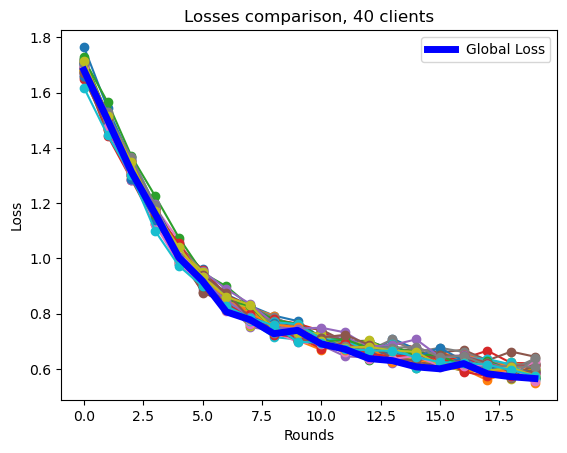

In [10]:
ax = plot_losses()
plt.show()

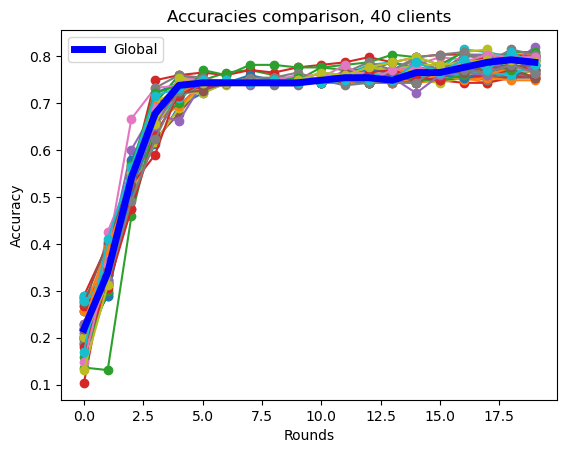

In [11]:
ax = plot_accuracies()
plt.show()